In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from tabulate import tabulate
from datetime import datetime
from meteostat import Point, Daily
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
%matplotlib inline

In [2]:
def fetch_and_save_weather_data(start_date, end_date, location):
    
    try:
        point = Point(location[0], location[1])

        data = Daily(point, datetime(*start_date), datetime(*end_date)).fetch()

        weather_df = pd.DataFrame(data)

        weather_df.reset_index(inplace=True)

        return weather_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
def merge_on_date(df1, df2, date_column='Date', date_format='%m/%d/%Y'):
    
    for df in [df1, df2]:
        if 'time' in df.columns:
            df.rename(columns={'time': date_column}, inplace=True)
   
    for df in [df1, df2]:
        if date_column in df.columns:
            df[date_column] = pd.to_datetime(df[date_column], errors='coerce').dt.strftime(date_format)

    merged_df = pd.merge(df1, df2, on=date_column, how='inner')
    
    return merged_df

In [4]:
def filter_correlated_columns(data, target_column, threshold=0.1):
    
    if target_column not in data.columns:
        raise ValueError(f"Target column '{target_column}' not found in the DataFrame.")

    correlation_matrix = data.corr()

    target_correlation = correlation_matrix[target_column]

    correlated_columns = target_correlation[abs(target_correlation) > threshold].index

    return data[correlated_columns]

In [5]:
def label_gen(x):
    if (x<51):
        return 'Good'
    elif (x<101):
        return 'Moderate'
    elif (x<151):
        return 'Unhealthy for sensitive groups'
    elif (x<201):
        return 'Unhealthy'
    elif (x<301):
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

In [6]:
def get_best_algorithm(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)
    algorithms = {
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, min_samples_split=5, min_samples_leaf=3),
        "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=5, max_iter=10000),
        "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=5, criterion='entropy', random_state=0),
        "SVM": SVC(probability=True, random_state=5),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2),
        "CatBoost": CatBoostClassifier(iterations=500,learning_rate=0.1,depth=6,random_seed=5,verbose=False),
        "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, random_state=5)
    }
    results = []

    for name, model in algorithms.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred) * 100
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0) * 100
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0) * 100
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0) * 100

        results.append({
            "Algorithm": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })

    results = sorted(results, key=lambda x: x["F1-Score"], reverse=True)
    best_algorithm = results[0] 
    return best_algorithm["Algorithm"]

In [7]:
def predict_air_quality_class(prediction):
    
    if prediction == 0:
        return "Good"
    elif prediction == 1:
        return "Moderate"
    elif prediction == 2:
        return "Unhealthy for sensitive groups"
    elif prediction == 3:
        return "Unhealthy"
    elif prediction == 4:
        return "Very Unhealthy"
    elif prediction == 5:
        return "Hazardous"
    else:
        return "INCORRECT PREDICTION"


In [8]:
PB_wet_data= fetch_and_save_weather_data((2017, 1, 1), (2023, 12, 31), (40.440624, -79.995888)) # Location of Pittsburgh, PA
PB_wet_data.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2017-01-01,2.8,-1.0,6.7,0.3,0.0,NaN,7.2,NaN,1021.8,NaN
1,2017-01-02,4.8,2.2,8.3,2.5,0.0,107.0,11.2,NaN,1022.0,NaN
2,2017-01-03,7.1,5.6,9.4,24.9,0.0,125.0,11.2,NaN,1006.5,NaN
3,2017-01-04,3.8,-5.5,6.1,0.0,0.0,275.0,27.0,NaN,1007.6,NaN
4,2017-01-05,-6.2,-8.2,-5.5,2.3,0.0,248.0,13.7,NaN,1015.4,NaN


In [9]:
aqd17= pd.read_csv('aqidaily2017.csv')
aqd18= pd.read_csv('aqidaily2018.csv')
aqd19= pd.read_csv('aqidaily2019.csv')
aqd20= pd.read_csv('aqidaily2020.csv')
aqd21= pd.read_csv('aqidaily2021.csv')
aqd22= pd.read_csv('aqidaily2022.csv')
aqd23= pd.read_csv('aqidaily2023.csv')
PB_aqi_data = pd.concat([aqd17,aqd18, aqd19, aqd20, aqd21, aqd22, aqd23], ignore_index=True)

PB_wet_aqi_data = merge_on_date(PB_aqi_data,PB_wet_data, date_column='Date', date_format='%m/%d/%Y')
PB_wet_aqi_data.head()

,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,01/01/2017,70,PM2.5,Kittanning,42-005-0001,AQS,6,31,13,70,...,2.8,-1.0,6.7,0.3,0.0,NaN,7.2,NaN,1021.8,NaN
1,01/02/2017,71,PM2.5,Beaver Falls,42-007-0014,AQS,6,28,14,71,...,4.8,2.2,8.3,2.5,0.0,107.0,11.2,NaN,1022.0,NaN
2,01/03/2017,55,PM2.5,Kittanning,42-005-0001,AQS,7,25,6,55,...,7.1,5.6,9.4,24.9,0.0,125.0,11.2,NaN,1006.5,NaN
3,01/04/2017,61,PM2.5,Kittanning,42-005-0001,AQS,7,34,7,61,...,3.8,-5.5,6.1,0.0,0.0,275.0,27.0,NaN,1007.6,NaN
4,01/05/2017,63,PM2.5,Kittanning,42-005-0001,AQS,3,33,13,63,...,-6.2,-8.2,-5.5,2.3,0.0,248.0,13.7,NaN,1015.4,NaN


In [10]:
PB_wet_aqi_data.isna().sum()

Date                             0
Overall AQI Value                0
Main Pollutant                   0
Site Name (of Overall AQI)     266
Site ID (of Overall AQI)         0
Source (of Overall AQI)          0
CO                               0
Ozone                            0
PM10                             0
PM25                             0
NO2                              0
tavg                             0
tmin                             0
tmax                             0
prcp                             0
snow                             0
wdir                           201
wspd                             0
wpgt                          2556
pres                             2
tsun                          2556
dtype: int64

In [11]:
columns_to_drop = ['Main Pollutant','Site Name (of Overall AQI)','Site ID (of Overall AQI)','Source (of Overall AQI)', 'wpgt', 'tsun']
PB_wet_aqi_data = PB_wet_aqi_data.drop(columns=columns_to_drop)
PB_wet_aqi_data.isna().sum()

Date                   0
Overall AQI Value      0
CO                     0
Ozone                  0
PM10                   0
PM25                   0
NO2                    0
tavg                   0
tmin                   0
tmax                   0
prcp                   0
snow                   0
wdir                 201
wspd                   0
pres                   2
dtype: int64


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='wdir', ylabel='Density'>

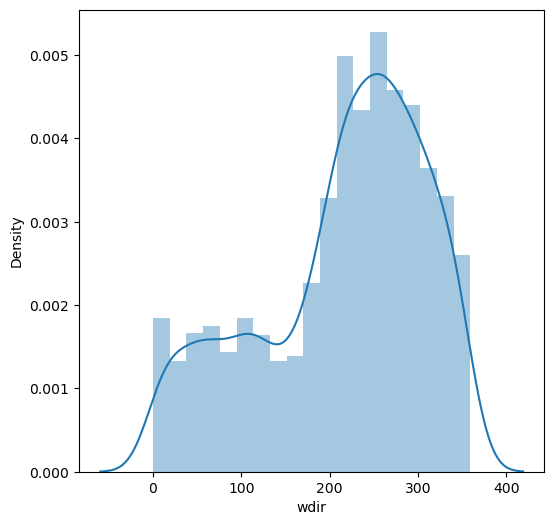

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
sn.distplot(PB_wet_aqi_data.wdir)

In [13]:
PB_wet_aqi_data['wdir'].fillna(PB_wet_aqi_data['wdir'].median(), inplace= True)
PB_wet_aqi_data.replace([np.nan], 0, inplace = True)
PB_wet_aqi_data.isna().sum()

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Date                 0
Overall AQI Value    0
CO                   0
Ozone                0
PM10                 0
PM25                 0
NO2                  0
tavg                 0
tmin                 0
tmax                 0
prcp                 0
snow                 0
wdir                 0
wspd                 0
pres                 0
dtype: int64

In [14]:
PB_wet_aqi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               2556 non-null   object 
 1   Overall AQI Value  2556 non-null   int64  
 2   CO                 2556 non-null   int64  
 3   Ozone              2556 non-null   int64  
 4   PM10               2556 non-null   int64  
 5   PM25               2556 non-null   int64  
 6   NO2                2556 non-null   int64  
 7   tavg               2556 non-null   float64
 8   tmin               2556 non-null   float64
 9   tmax               2556 non-null   float64
 10  prcp               2556 non-null   float64
 11  snow               2556 non-null   float64
 12  wdir               2556 non-null   float64
 13  wspd               2556 non-null   float64
 14  pres               2556 non-null   float64
dtypes: float64(8), int64(6), object(1)
memory usage: 299.7+ KB


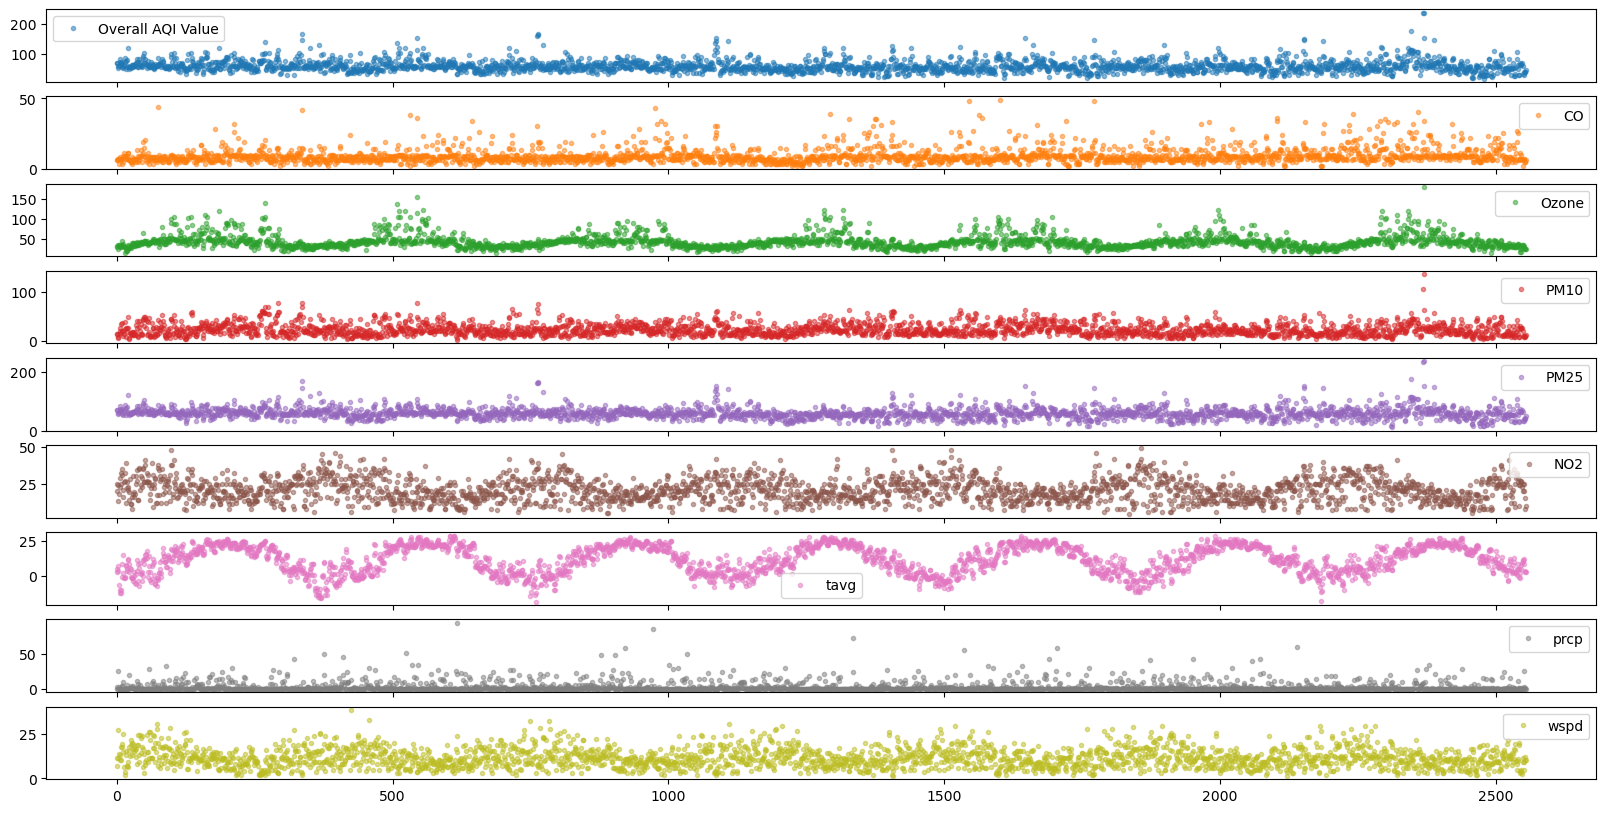

In [15]:
colsplot= ['Overall AQI Value','CO','Ozone','PM10','PM25','NO2','tavg','prcp','wspd']
axes= PB_wet_aqi_data[colsplot].plot(marker='.',alpha=0.5, linestyle= 'none', figsize=(20,10), subplots= True)

# Applying PCC

In [16]:
PB_wet_aqi_data = PB_wet_aqi_data.select_dtypes(include=[np.number])
PB_wet_aqi_data.info()
cor = PB_wet_aqi_data.corr()
cor_target = abs(cor['Overall AQI Value'])
relevant_features = cor_target[cor_target > 0.2]
print(relevant_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Overall AQI Value  2556 non-null   int64  
 1   CO                 2556 non-null   int64  
 2   Ozone              2556 non-null   int64  
 3   PM10               2556 non-null   int64  
 4   PM25               2556 non-null   int64  
 5   NO2                2556 non-null   int64  
 6   tavg               2556 non-null   float64
 7   tmin               2556 non-null   float64
 8   tmax               2556 non-null   float64
 9   prcp               2556 non-null   float64
 10  snow               2556 non-null   float64
 11  wdir               2556 non-null   float64
 12  wspd               2556 non-null   float64
 13  pres               2556 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 279.7 KB
Overall AQI Value    1.000000
CO                   0.472654
Ozone        

In [17]:
pcc_data= filter_correlated_columns(PB_wet_aqi_data, 'Overall AQI Value', threshold=0.2)
pcc_data.head()

,Overall AQI Value,CO,Ozone,PM10,PM25,NO2,tmax,wspd
0,70,6,31,13,70,20,6.7,7.2
1,71,6,28,14,71,25,8.3,11.2
2,55,7,25,6,55,24,9.4,11.2
3,61,7,34,7,61,13,6.1,27.0
4,63,3,33,13,63,18,-5.5,13.7


In [18]:
pcc_data['AQI Label']= pcc_data['Overall AQI Value'].apply(func=label_gen) #Applying the label_gen function
pcc_data.drop(['Overall AQI Value'],axis=1,inplace=True)
pcc_data= pd.DataFrame(pcc_data)
pcc_data.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CO,Ozone,PM10,PM25,NO2,tmax,wspd,AQI Label
0,6,31,13,70,20,6.7,7.2,Moderate
1,6,28,14,71,25,8.3,11.2,Moderate
2,7,25,6,55,24,9.4,11.2,Moderate
3,7,34,7,61,13,6.1,27.0,Moderate
4,3,33,13,63,18,-5.5,13.7,Moderate


In [19]:
X = pcc_data
Y = pcc_data['AQI Label']
X.drop('AQI Label', axis=1, inplace=True)

In [20]:
X.head()

,CO,Ozone,PM10,PM25,NO2,tmax,wspd
0,6,31,13,70,20,6.7,7.2
1,6,28,14,71,25,8.3,11.2
2,7,25,6,55,24,9.4,11.2
3,7,34,7,61,13,6.1,27.0
4,3,33,13,63,18,-5.5,13.7


In [21]:
le= LabelEncoder()
sc = StandardScaler()
X = sc.fit_transform(X)
Y= le.fit_transform(Y)

xtrain,xtest,ytrain,ytest= train_test_split(X,Y, test_size= 0.3, stratify=Y, random_state= 5)
xtest1= xtest

# After SMOTE

In [22]:
smote = SMOTE(random_state=5, k_neighbors=1)

x_train_smote, y_train_smote = smote.fit_resample(xtrain, ytrain)

In [23]:
print("Original class distribution:", Counter(Y))

Original class distribution: Counter({1: 1875, 0: 579, 3: 90, 2: 10, 4: 2})


In [24]:
print("Class distribution after SMOTE:", Counter(y_train_smote))

Class distribution after SMOTE: Counter({1: 1312, 0: 1312, 2: 1312, 4: 1312, 3: 1312})


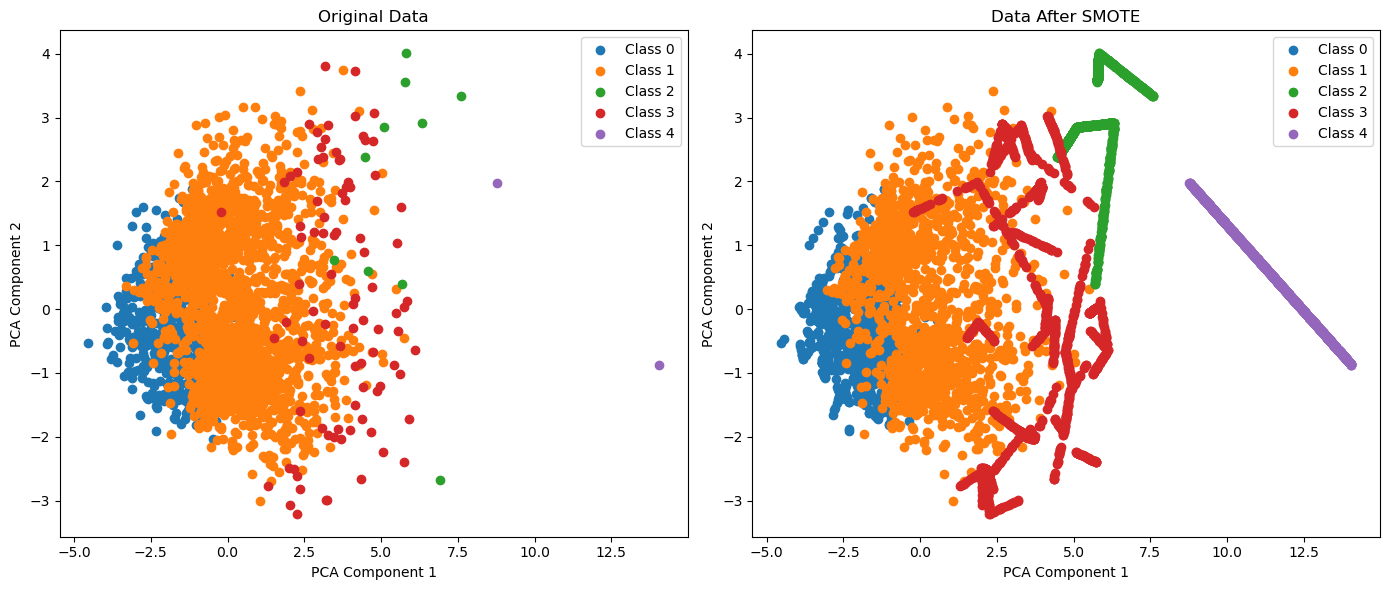

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(x_train_smote)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for label in np.unique(Y):
    mask = Y == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Class {label}")
plt.title("Original Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

plt.subplot(1, 2, 2)
for label in np.unique(y_train_smote):
    mask = y_train_smote == label
    plt.scatter(X_resampled_pca[mask, 0], X_resampled_pca[mask, 1], label=f"Class {label}")
plt.title("Data After SMOTE")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
print("The Best Machine Learning Algorithm (With SMOTE)is ", get_best_algorithm(x_train_smote, y_train_smote))

The Best Machine Learning Algorithm (With SMOTE)is  Gradient Boosting


# CatBoost

In [27]:
model3= CatBoostClassifier(iterations=500,learning_rate=0.1,depth=6,random_seed=5,verbose=False)

In [28]:
model3.fit(x_train_smote, y_train_smote)
pred3= model3.predict(xtest)
cr3=classification_report(ytest,pred3, zero_division=0)
print(cr3)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      1.00      1.00       563
           2       0.67      0.67      0.67         3
           3       0.96      0.96      0.96        27

    accuracy                           1.00       767
   macro avg       0.91      0.91      0.91       767
weighted avg       1.00      1.00      1.00       767



In [29]:
A3 = accuracy_score(ytest, pred3)*100
P3 = precision_score(ytest, pred3, average='weighted',zero_division=0)*100
R3 = recall_score(ytest, pred3, average='weighted',zero_division=0)*100
f1_3 = f1_score(ytest, pred3, average='weighted',zero_division=0)*100

print("CatBoost Accuracy:",A3)
print("CatBoost Precision:", P3)
print("CatBoost Recall:", R3)
print("CatBoost F1 Score :", f1_3)

CatBoost Accuracy: 99.73924380704041
CatBoost Precision: 99.73924380704041
CatBoost Recall: 99.73924380704041
CatBoost F1 Score : 99.73924380704041


In [30]:
scores = cross_val_score(model3, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 99.95426829268294


1 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\AppData\Roaming\Python\Python312\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\User\AppData\Roaming\Python\Python312\site-packages\catboost\core.py", line 2410, in _fit
    self._train(
  File "C:\Users\User\AppData\Roaming\Pyt

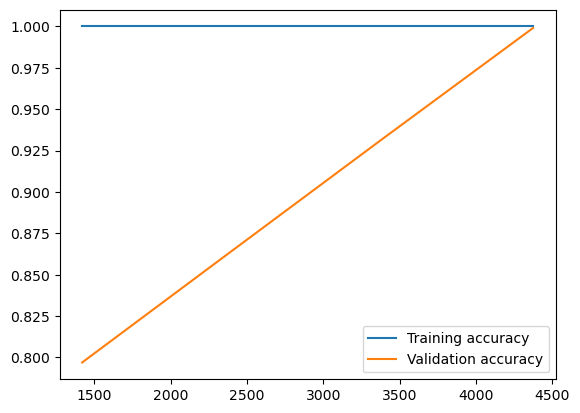

In [31]:
train_sizes, train_scores, test_scores = learning_curve(model3, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# Stacked Classifier 

In [32]:
base_models = [
    ('rf', RandomForestClassifier(class_weight='balanced',n_estimators= 5, criterion= 'entropy', random_state=0)),
    ('gb', GradientBoostingClassifier(n_estimators= 100, learning_rate=0.05, max_depth= 3, min_samples_split= 5, min_samples_leaf= 3)),
    ('svc', SVC(probability=True, random_state=5)),
    ('knn', KNeighborsClassifier(n_neighbors = 5, metric= 'minkowski', p=2))
]
meta_model = LogisticRegression(random_state=5)

stacked_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=2)
stacked_clf.fit(x_train_smote, y_train_smote)
pred0= stacked_clf.predict(xtest)
cr0=classification_report(ytest,pred0, zero_division=0)
print(cr0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      1.00      1.00       563
           2       1.00      0.33      0.50         3
           3       0.93      0.96      0.95        27

    accuracy                           1.00       767
   macro avg       0.98      0.82      0.86       767
weighted avg       1.00      1.00      1.00       767



Text(95.72222222222221, 0.5, 'Actual')

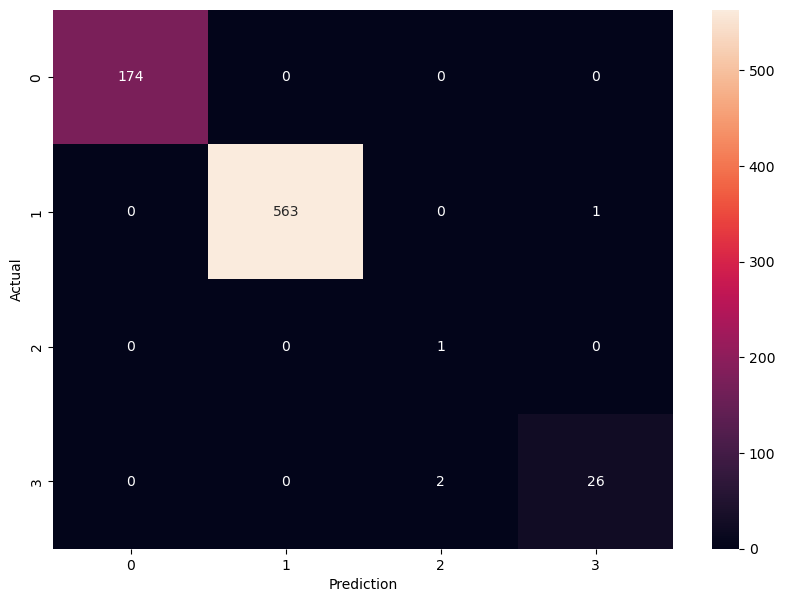

In [33]:
cm= confusion_matrix(pred0, ytest)
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot= True, fmt= 'd')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [34]:
A0= accuracy_score(ytest, pred0)*100
P0= precision_score(ytest, pred0, average='weighted',zero_division=0)*100
R0 = recall_score(ytest, pred0, average='weighted',zero_division=0)*100
f1_0 = f1_score(ytest, pred0, average='weighted',zero_division=0)*100

print("Stacked Classifier Accuracy:", A0)
print("Stacked Classifier Precision:", P0)
print("Stacked Classifier Recall:", R0)
print("Stacked Classifier F1 Score: ",f1_0)


Stacked Classifier Accuracy: 99.60886571056062
Stacked Classifier Precision: 99.61840959857548
Stacked Classifier Recall: 99.60886571056062
Stacked Classifier F1 Score:  99.54729027157703


1 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py", line 669, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\

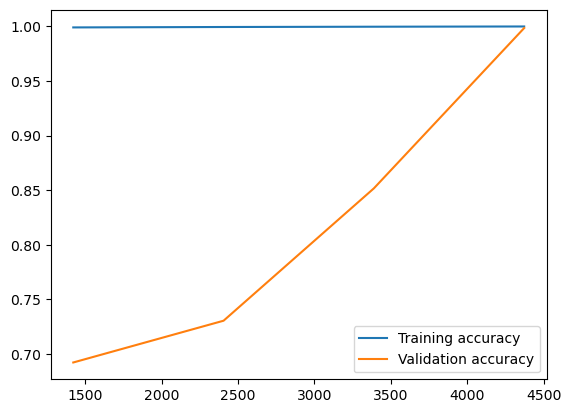

In [35]:
train_sizes, train_scores, test_scores = learning_curve(stacked_clf, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# Logistic Regression

In [36]:
model1= LogisticRegression(class_weight='balanced',random_state=5,max_iter=1000)
model1.fit(x_train_smote, y_train_smote)
pred1= model1.predict(xtest)
cr1=classification_report(ytest,pred1, zero_division=0)
print(cr1)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       174
           1       0.99      0.95      0.97       563
           2       1.00      0.67      0.80         3
           3       0.51      0.96      0.67        27

    accuracy                           0.96       767
   macro avg       0.87      0.89      0.86       767
weighted avg       0.97      0.96      0.96       767



Text(95.72222222222221, 0.5, 'Actual')

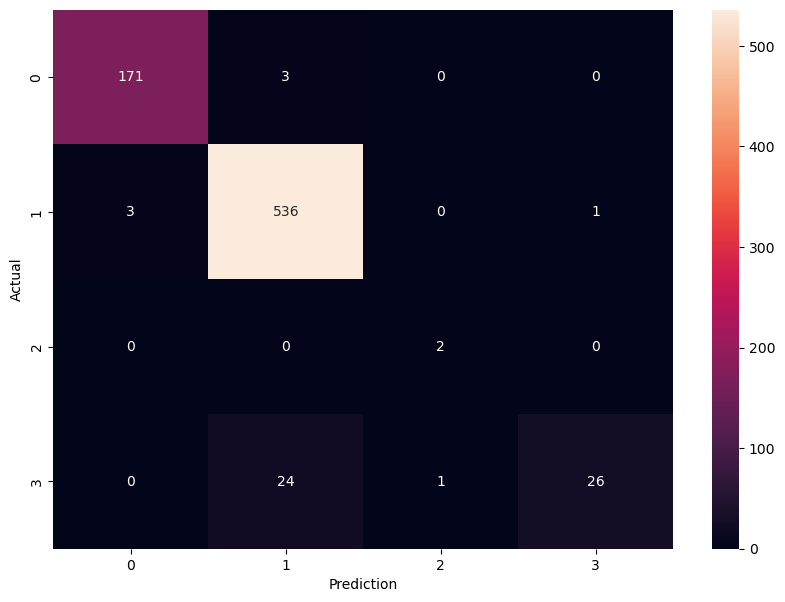

In [37]:
cm= confusion_matrix(pred1, ytest)
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot= True, fmt= 'd')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [38]:
A1 = accuracy_score(ytest, pred1)*100
P1 = precision_score(ytest, pred1, average='weighted')*100
R1 = recall_score(ytest, pred1, average='weighted')*100
f1_1 = f1_score(ytest, pred1, average='weighted',zero_division=0)*100

print("Logistic Regression Accuracy:",A1)
print("Logistic Regression Precision:", P1)
print("Logistic Regression Recall:", R1)
print("Logistic Regression F1 Score :", f1_1)

Logistic Regression Accuracy: 95.82790091264668
Logistic Regression Precision: 97.339548306647
Logistic Regression Recall: 95.82790091264668
Logistic Regression F1 Score : 96.29423605882262


In [39]:
scores = cross_val_score(model1, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 98.4908536585366


1 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1246, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only 

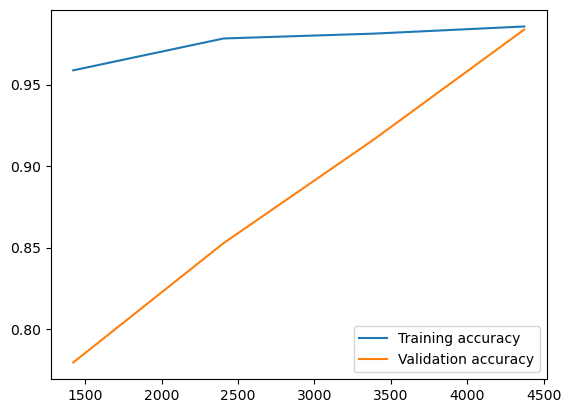

In [40]:
train_sizes, train_scores, test_scores = learning_curve(model1, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# Random Forest

In [41]:
model2= RandomForestClassifier(class_weight='balanced',n_estimators= 5, criterion= 'entropy', random_state=0)
model2.fit(x_train_smote, y_train_smote)
pred2= model2.predict(xtest)
cr2=classification_report(ytest,pred2, zero_division=0)
print(cr2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      0.99      1.00       563
           2       1.00      0.67      0.80         3
           3       0.82      1.00      0.90        27

    accuracy                           0.99       767
   macro avg       0.95      0.91      0.92       767
weighted avg       0.99      0.99      0.99       767



Text(95.72222222222221, 0.5, 'Actual')

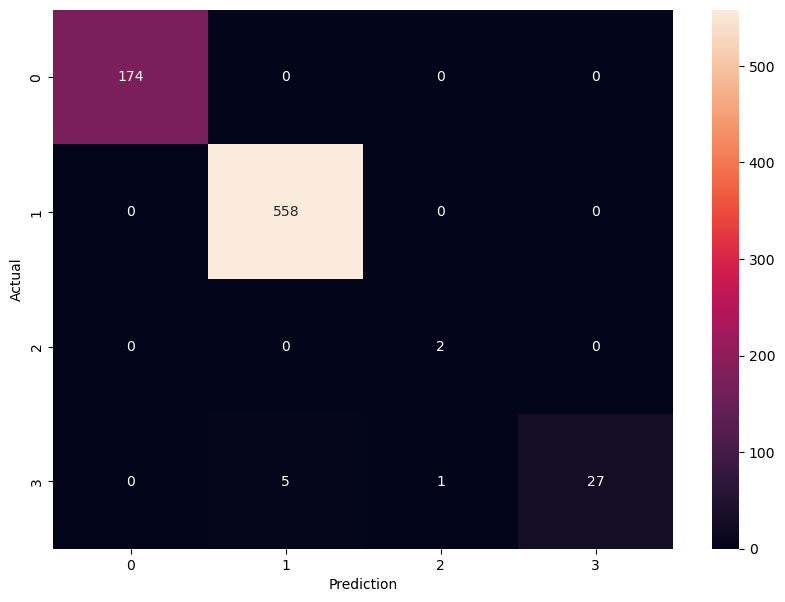

In [42]:
cm= confusion_matrix(pred2, ytest)
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot= True, fmt= 'd')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [43]:
A2 = accuracy_score(ytest, pred2)*100
P2 = precision_score(ytest, pred2, average='weighted',zero_division=0)*100
R2 = recall_score(ytest, pred2, average='weighted',zero_division=0)*100
f1_2 = f1_score(ytest, pred2, average='weighted',zero_division=0)*100

print("Random Forest Accuracy:",A2)
print("Random Forest Precision:", P2)
print("Random Forest Recall:", R2)
print("Random Forest F1 Score :", f1_2)

Random Forest Accuracy: 99.21773142112124
Random Forest Precision: 99.35996207182647
Random Forest Recall: 99.21773142112124
Random Forest F1 Score : 99.24235322578205


In [44]:
scores = cross_val_score(model2, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 99.83231707317073


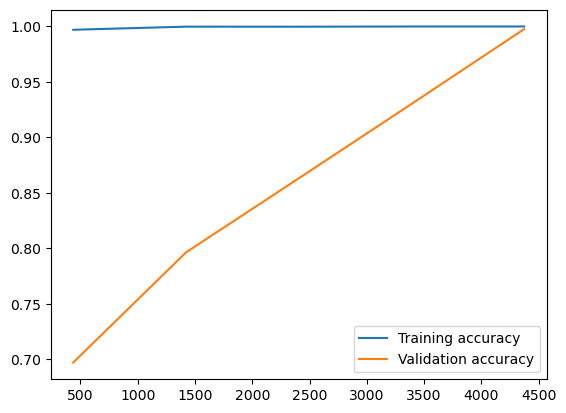

In [45]:
train_sizes, train_scores, test_scores = learning_curve(model2, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# Gradient Boost

In [46]:
model7= GradientBoostingClassifier(n_estimators= 100, learning_rate=0.05, max_depth= 3, min_samples_split= 5, min_samples_leaf= 3)
model7.fit(x_train_smote, y_train_smote)
pred7= model7.predict(xtest)
cr7=classification_report(ytest,pred7, zero_division=0)
print(cr7)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      1.00      1.00       563
           2       1.00      0.67      0.80         3
           3       0.96      1.00      0.98        27

    accuracy                           1.00       767
   macro avg       0.99      0.92      0.95       767
weighted avg       1.00      1.00      1.00       767



Text(95.72222222222221, 0.5, 'Actual')

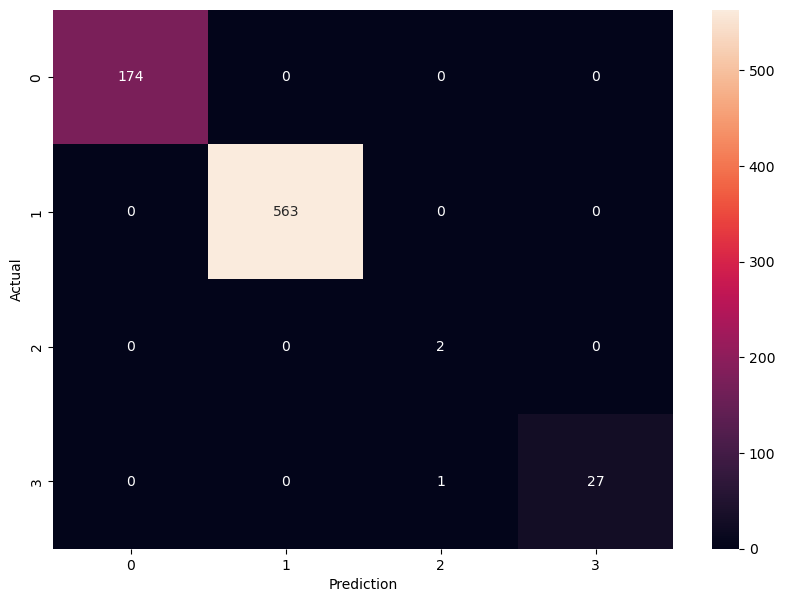

In [47]:
cm= confusion_matrix(pred7, ytest)
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot= True, fmt= 'd')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
A7 = accuracy_score(ytest, pred7)*100
P7 = precision_score(ytest, pred7, average='weighted')*100
R7 = recall_score(ytest, pred7, average='weighted')*100
f1_7 = f1_score(ytest, pred7, average='weighted',zero_division=0)*100

print("Gradient Boost Accuracy:",A7)
print("Gradient Boost Precision:", P7)
print("Gradient Boost Recall:", R7)
print("Gradient Boost F1 Score:", f1_7)

Gradient Boost Accuracy: 99.86962190352021
Gradient Boost Precision: 99.87427826410877
Gradient Boost Recall: 99.86962190352021
Gradient Boost F1 Score: 99.85776934929477


In [49]:
scores = cross_val_score(model7, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 100.0


1 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py", line 665, in fit
    y = self._encode_y(y=y, sample_weight=None)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\

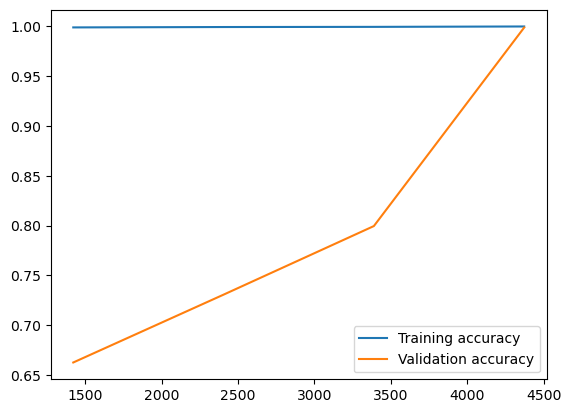

In [50]:
train_sizes, train_scores, test_scores = learning_curve(model7, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# Decision Tree

In [51]:
from sklearn import tree
model4= tree.DecisionTreeClassifier(max_depth= 6, min_samples_leaf= 3, random_state= 5)
model4.fit(x_train_smote, y_train_smote)
pred4= model4.predict(xtest)
cr4= classification_report(ytest, pred4)
print(cr4)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      0.98      0.99       563
           2       1.00      0.67      0.80         3
           3       0.68      0.96      0.80        27

    accuracy                           0.98       767
   macro avg       0.92      0.90      0.90       767
weighted avg       0.99      0.98      0.98       767



In [52]:
A4 = accuracy_score(ytest, pred4)*100
P4 = precision_score(ytest, pred4, average='weighted')*100
R4 = recall_score(ytest, pred4, average='weighted')*100
f1_4 = f1_score(ytest, pred4, average='weighted',zero_division=0)*100

print("Decision Tree Accuracy:",A4)
print("Decision Tree Precision:", P4)
print("Decision Tree Recall:", R4)
print("Decision Tree F1 Score: ", f1_4)

Decision Tree Accuracy: 98.30508474576271
Decision Tree Precision: 98.75561942997213
Decision Tree Recall: 98.30508474576271
Decision Tree F1 Score:  98.42845326716295


In [53]:
scores = cross_val_score(model4, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 99.77134146341464


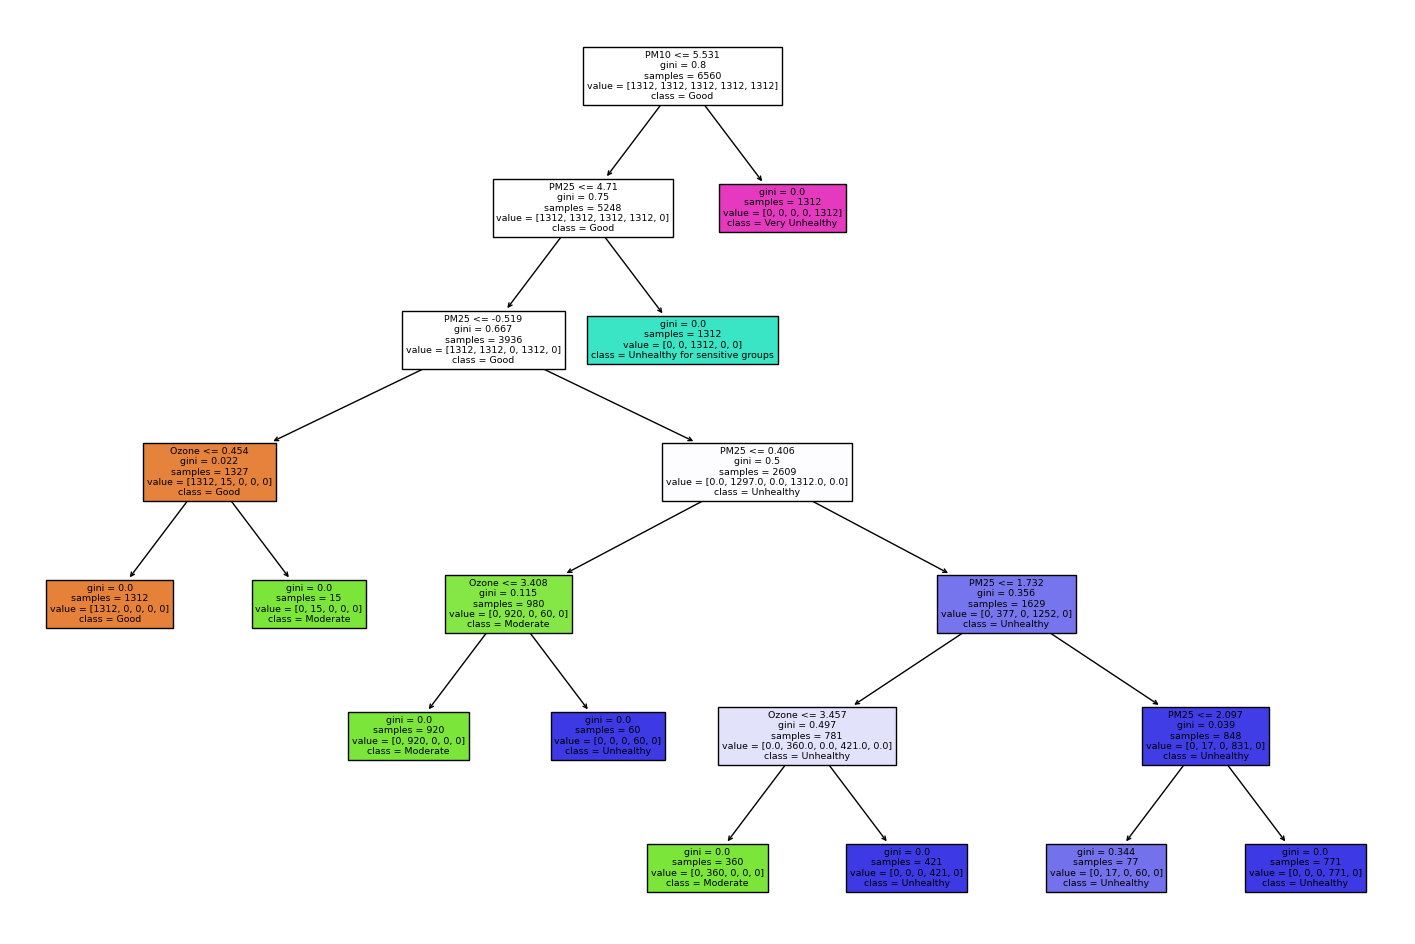

In [54]:
fn= ['CO','Ozone','PM10','PM25','NO2','tmax','wspd']
cn= ['Good', 'Moderate', 'Unhealthy for sensitive groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
fig= plt.figure(figsize=  (18,12))
_= tree.plot_tree(model4, feature_names=fn, class_names=cn,filled= True)

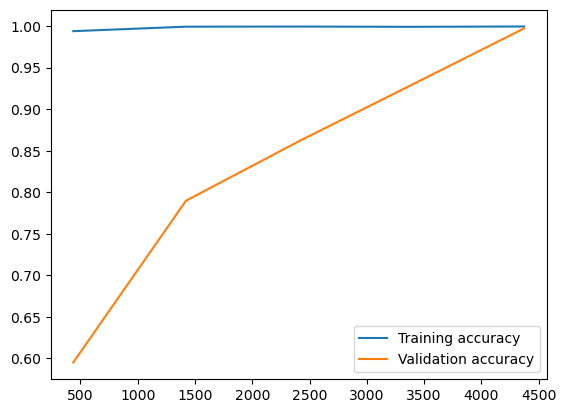

In [55]:
train_sizes, train_scores, test_scores = learning_curve(model4, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# KNN

In [56]:
model5= KNeighborsClassifier(n_neighbors = 5, metric= 'minkowski', p=2)
model5.fit(x_train_smote, y_train_smote)

pred5= model5.predict(xtest)
cr5 = classification_report(ytest, pred5)
print(cr5)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       174
           1       0.97      0.93      0.95       563
           2       0.00      0.00      0.00         3
           3       0.63      0.81      0.71        27

    accuracy                           0.93       767
   macro avg       0.61      0.67      0.64       767
weighted avg       0.93      0.93      0.93       767



Text(95.72222222222221, 0.5, 'Actual')

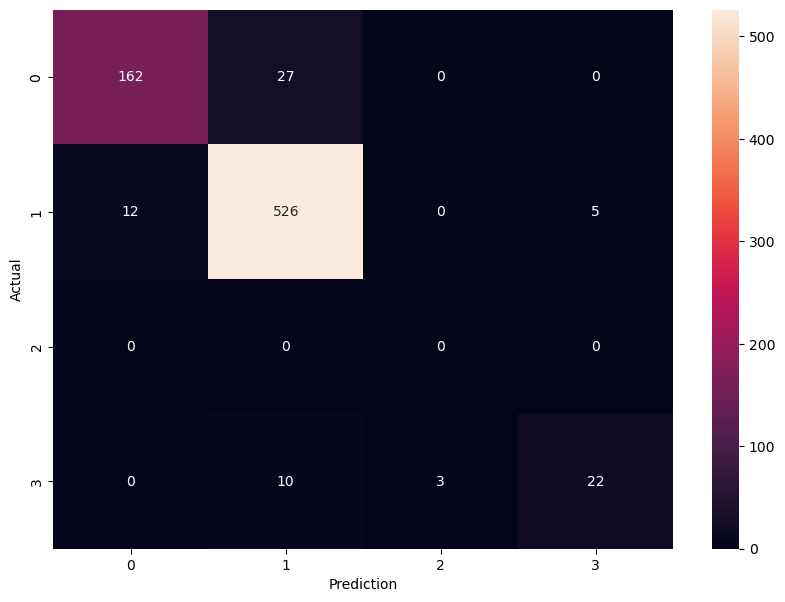

In [57]:
cm= confusion_matrix(pred5, ytest)
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot= True, fmt= 'd')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [58]:
A5 = accuracy_score(ytest, pred5)*100
P5 = precision_score(ytest, pred5, average='weighted')*100
R5 = recall_score(ytest, pred5, average='weighted')*100
f1_5 = f1_score(ytest, pred5, average='weighted',zero_division=0)*100

print("KNN Accuracy:",A5)
print("KNN Precision:", P5)
print("KNN Recall:", R5)
print("KNN F1 Score:", f1_5)

KNN Accuracy: 92.5684485006519
KNN Precision: 92.7624686703252
KNN Recall: 92.5684485006519
KNN F1 Score: 92.5656883331504


In [59]:
scores = cross_val_score(model5, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 97.80487804878048


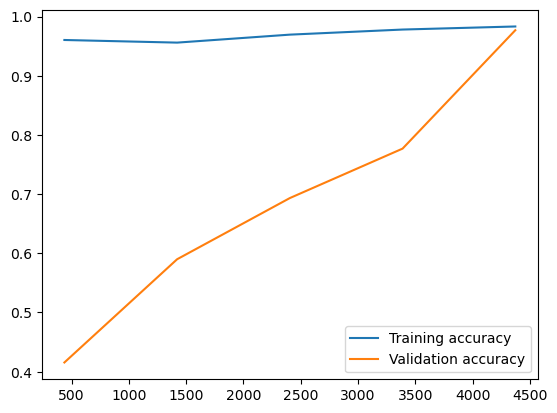

In [60]:
train_sizes, train_scores, test_scores = learning_curve(model5, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# SVM

In [61]:
from sklearn import svm
model6 = svm.SVC(probability=True, random_state=5)
model6.fit(x_train_smote, y_train_smote)
pred6= model6.predict(xtest)
cr6= classification_report(ytest, pred6)
print(cr6)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       174
           1       0.99      0.95      0.97       563
           2       0.50      0.67      0.57         3
           3       0.57      0.89      0.70        27

    accuracy                           0.96       767
   macro avg       0.75      0.87      0.80       767
weighted avg       0.96      0.96      0.96       767



Text(95.72222222222221, 0.5, 'Actual')

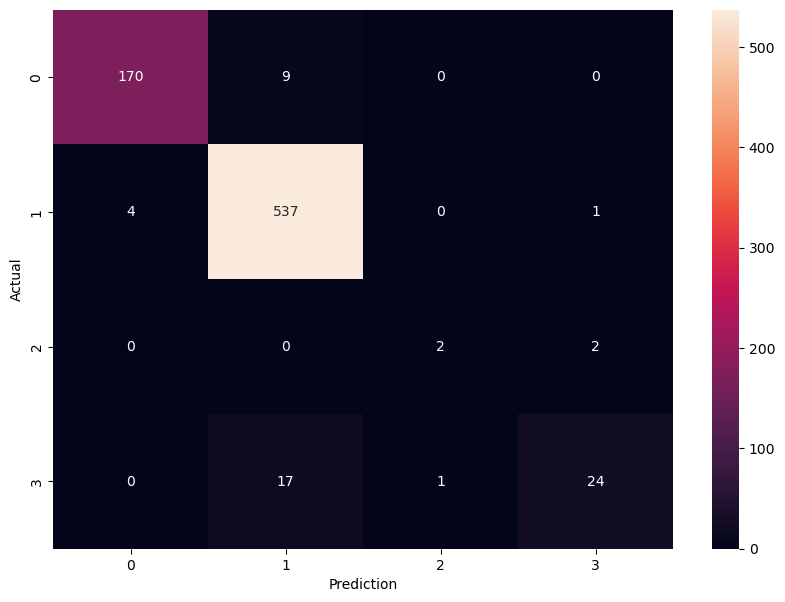

In [62]:
cm= confusion_matrix(pred6, ytest)
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot= True, fmt= 'd')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [63]:
A6 = accuracy_score(ytest, pred6)*100
P6 = precision_score(ytest, pred6, average='weighted')*100
R6 = recall_score(ytest, pred6, average='weighted')*100
f1_6 = f1_score(ytest, pred6, average='weighted',zero_division=0)*100

print("SVM Accuracy:",A6)
print("SVM Precision:", P6)
print("SVM Recall:", R6)
print("SVM F1 Score:", f1_6)

SVM Accuracy: 95.5671447196871
SVM Precision: 96.47799754098394
SVM Recall: 95.5671447196871
SVM F1 Score: 95.8662832154967


In [64]:
scores = cross_val_score(model6, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 98.3079268292683


1 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base

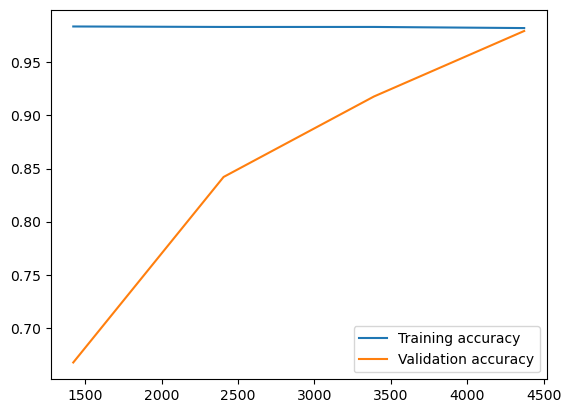

In [65]:
train_sizes, train_scores, test_scores = learning_curve(model6, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# Performance Evaluation

In [66]:
algorithms = {
        "Logistic Regression": model1,
        "Random Forest": model2,
        "SVM": model6,
        "K-Nearest Neighbors": model5,
        "Decision Tree": model4,
        "Gradient Boosting": model7,
        "Stack Classifier" : stacked_clf,
        "CatBoost" : model3
}

results = []

for name, model in algorithms.items():

    start_time = time.perf_counter()
    model.fit(x_train_smote, y_train_smote)
    training_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred = model.predict(xtest)
    prediction_time = time.perf_counter() - start_time

    accuracy = accuracy_score(ytest, y_pred) * 100
    precision = precision_score(ytest, y_pred, average='weighted', zero_division=0) * 100
    recall = recall_score(ytest, y_pred, average='weighted', zero_division=0) * 100
    f1 = f1_score(ytest, y_pred, average='weighted', zero_division=0) * 100

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Training Time (s)": training_time,
        "Prediction Time (s)": prediction_time
    })

results_df = pd.DataFrame(results)
sorted_results = results_df.sort_values(by='F1-Score', ascending=False)
print(tabulate(sorted_results, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════════════╤════════════╤═════════════╤══════════╤════════════╤═════════════════════╤═══════════════════════╕
│    │ Model               │   Accuracy │   Precision │   Recall │   F1-Score │   Training Time (s) │   Prediction Time (s) │
╞════╪═════════════════════╪════════════╪═════════════╪══════════╪════════════╪═════════════════════╪═══════════════════════╡
│  5 │ Gradient Boosting   │    99.8696 │     99.8743 │  99.8696 │    99.8578 │           5.26644   │             0.0038387 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┼────────────┼─────────────────────┼───────────────────────┤
│  7 │ CatBoost            │    99.7392 │     99.7392 │  99.7392 │    99.7392 │           2.56292   │             0.0026877 │
├────┼─────────────────────┼────────────┼─────────────┼──────────┼────────────┼─────────────────────┼───────────────────────┤
│  6 │ Stack Classifier    │    99.6089 │     99.6184 │  99.6089 │    99.5473 │          11.8993    │             0.07

<Figure size 800x1000 with 0 Axes>

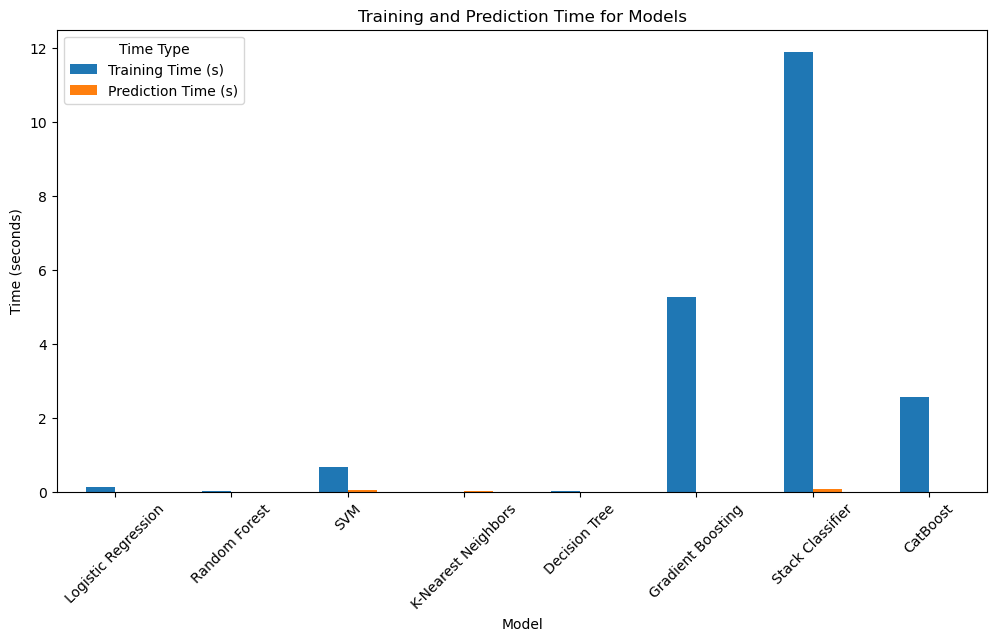

In [67]:
plt.figure(figsize=(8, 10))
results_df.plot(
    x='Model',
    y=['Training Time (s)', 'Prediction Time (s)'],
    kind='bar',
    figsize=(12, 6),
    title='Training and Prediction Time for Models'
)
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title="Time Type")
plt.show()


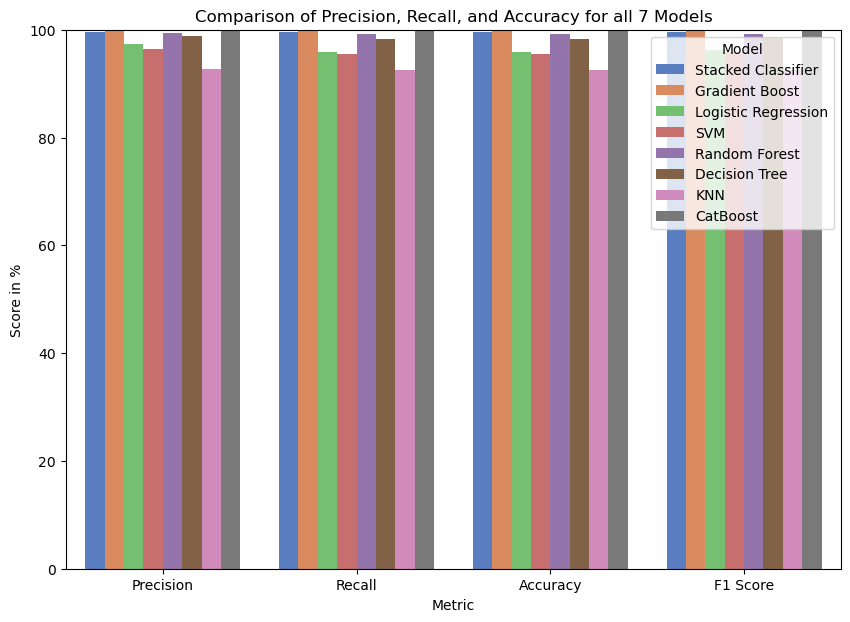

In [68]:
data = {
    'Metric': ['Precision', 'Recall', 'Accuracy', 'F1 Score'] * 8, 
    'Model': ['Stacked Classifier']*4 +['Gradient Boost']*4 + ['Logistic Regression']*4 + ['SVM']*4 +['Random Forest'] * 4 + ['Decision Tree'] * 4 + ['KNN']*4 + ['CatBoost']*4, 
    'Value': [P0,R0,A0,f1_0,
              P7,R7,A7,f1_7,
              P1,R1,A1,f1_1,
              P6,R6,A6,f1_6,
              P2,R2,A2,f1_2,
              P4,R4,A4,f1_4,
              P5,R5,A5,f1_5,
              P3,R3,A3,f1_3,
              ]
}

results_df = pd.DataFrame(data)

plt.figure(figsize=(10, 7))
sn.barplot(x='Metric', y='Value', hue='Model', data= results_df, palette='muted')
plt.title('Comparison of Precision, Recall, and Accuracy for all 7 Models')
plt.ylim(0, 100)
plt.xlabel('Metric')
plt.ylabel('Score in %')

plt.show()

In [69]:
location = Point(40.440624, -79.995888) #Location of Pittsburgh
start1 = datetime(2024, 1, 1)
end1 = datetime(2024, 1, 30)
data = Daily(location, start1, end1)
data = data.fetch()
dwp= pd.DataFrame(data)
dwp.head(3)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2024-01-01,1.8,0.0,3.3,2.0,0.0,267.0,13.7,NaN,1019.8,NaN
2024-01-02,0.7,0.0,1.7,0.0,0.0,244.0,11.2,NaN,1023.2,NaN
2024-01-03,1.5,0.0,5.0,0.0,0.0,222.0,11.5,NaN,1018.2,NaN


In [70]:
# CO	Ozone	PM10	PM25	NO2 	tmax	wspd 

#observation for 1/03/2024
observation1 =  [3,24,14,53,20,5.0,11.5]
observation1 =  pd.DataFrame(observation1)

print("---------------------------")
observation1= observation1.transpose()
observation1 = sc.fit_transform(observation1)
prediction1= model7.predict(observation1)
print("The AQI Level of concern is: ",predict_air_quality_class(prediction1))

---------------------------
The AQI Level of concern is:  Moderate


# Try New Data SET for AQI Label Prediction

In [71]:
BF_wet_data= fetch_and_save_weather_data((2016, 1, 1), (2019, 12, 31), (35.393528, -119.043732)) # Location of Bakers Field, CA
BF_wet_data.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2016-01-01,4.4,-2.7,12.8,0.0,0.0,NaN,6.5,NaN,1020.3,NaN
1,2016-01-02,7.1,1.1,13.9,0.0,0.0,NaN,3.6,NaN,1017.9,NaN
2,2016-01-03,9.6,3.9,20.0,0.0,0.0,NaN,11.5,NaN,1011.5,NaN
3,2016-01-04,10.6,5.6,18.3,0.0,0.0,NaN,7.2,NaN,1008.8,NaN
4,2016-01-05,12.5,8.3,14.4,12.2,0.0,NaN,7.6,NaN,1008.2,NaN


In [72]:
aqd216= pd.read_csv('aqidaily16.csv')
aqd217= pd.read_csv('aqidaily17.csv')
aqd218= pd.read_csv('aqidaily18.csv')
aqd219= pd.read_csv('aqidaily19.csv')
BF_aqi_data = pd.concat([aqd216,aqd217, aqd218, aqd219], ignore_index=True)

BF_wet_aqi_data = merge_on_date(BF_aqi_data,BF_wet_data, date_column='Date', date_format='%m/%d/%Y')
BF_wet_aqi_data.head()

,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,01/01/2016,148,PM2.5,Bakersfield-California,06-029-0014,AQS,8,37,52,148,...,4.4,-2.7,12.8,0.0,0.0,NaN,6.5,NaN,1020.3,NaN
1,01/02/2016,113,PM2.5,Bakersfield-California,06-029-0014,AQS,7,37,14,113,...,7.1,1.1,13.9,0.0,0.0,NaN,3.6,NaN,1017.9,NaN
2,01/03/2016,82,PM2.5,Bakersfield-California,06-029-0014,AQS,7,36,9,82,...,9.6,3.9,20.0,0.0,0.0,NaN,11.5,NaN,1011.5,NaN
3,01/04/2016,89,PM2.5,Bakersfield-Airport (Planz),06-029-0016,AQS,5,37,8,89,...,10.6,5.6,18.3,0.0,0.0,NaN,7.2,NaN,1008.8,NaN
4,01/05/2016,59,PM2.5,Bakersfield-California,06-029-0014,AQS,5,41,6,59,...,12.5,8.3,14.4,12.2,0.0,NaN,7.6,NaN,1008.2,NaN


In [73]:
BF_wet_aqi_data.isna().sum()

Date                             0
Overall AQI Value                0
Main Pollutant                   0
Site Name (of Overall AQI)       0
Site ID (of Overall AQI)         0
Source (of Overall AQI)          0
CO                               0
Ozone                            0
PM10                             0
PM25                             0
NO2                              0
tavg                             0
tmin                             0
tmax                             0
prcp                             0
snow                             0
wdir                           842
wspd                             0
wpgt                          1461
pres                             1
tsun                          1461
dtype: int64

In [74]:
columns_to_drop = ['Main Pollutant','Site Name (of Overall AQI)','Site ID (of Overall AQI)','Source (of Overall AQI)', 'wpgt', 'tsun']
BF_wet_aqi_data = BF_wet_aqi_data.drop(columns=columns_to_drop)
BF_wet_aqi_data.isna().sum()

Date                   0
Overall AQI Value      0
CO                     0
Ozone                  0
PM10                   0
PM25                   0
NO2                    0
tavg                   0
tmin                   0
tmax                   0
prcp                   0
snow                   0
wdir                 842
wspd                   0
pres                   1
dtype: int64

# Replacing the NaN Values


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='wdir', ylabel='Density'>

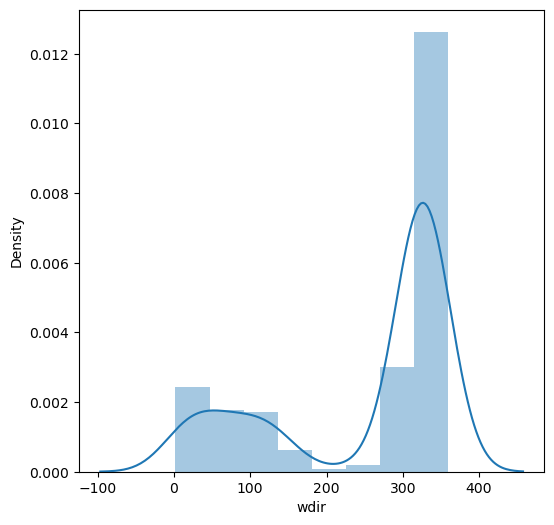

In [75]:
fig, ax = plt.subplots(figsize=(6,6))
sn.distplot(BF_wet_aqi_data.wdir)

In [76]:
BF_wet_aqi_data['wdir'].fillna(BF_wet_aqi_data['wdir'].mode(), inplace= True)
BF_wet_aqi_data.replace([np.nan], 0, inplace = True)
BF_wet_aqi_data.isna().sum()

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




Date                 0
Overall AQI Value    0
CO                   0
Ozone                0
PM10                 0
PM25                 0
NO2                  0
tavg                 0
tmin                 0
tmax                 0
prcp                 0
snow                 0
wdir                 0
wspd                 0
pres                 0
dtype: int64

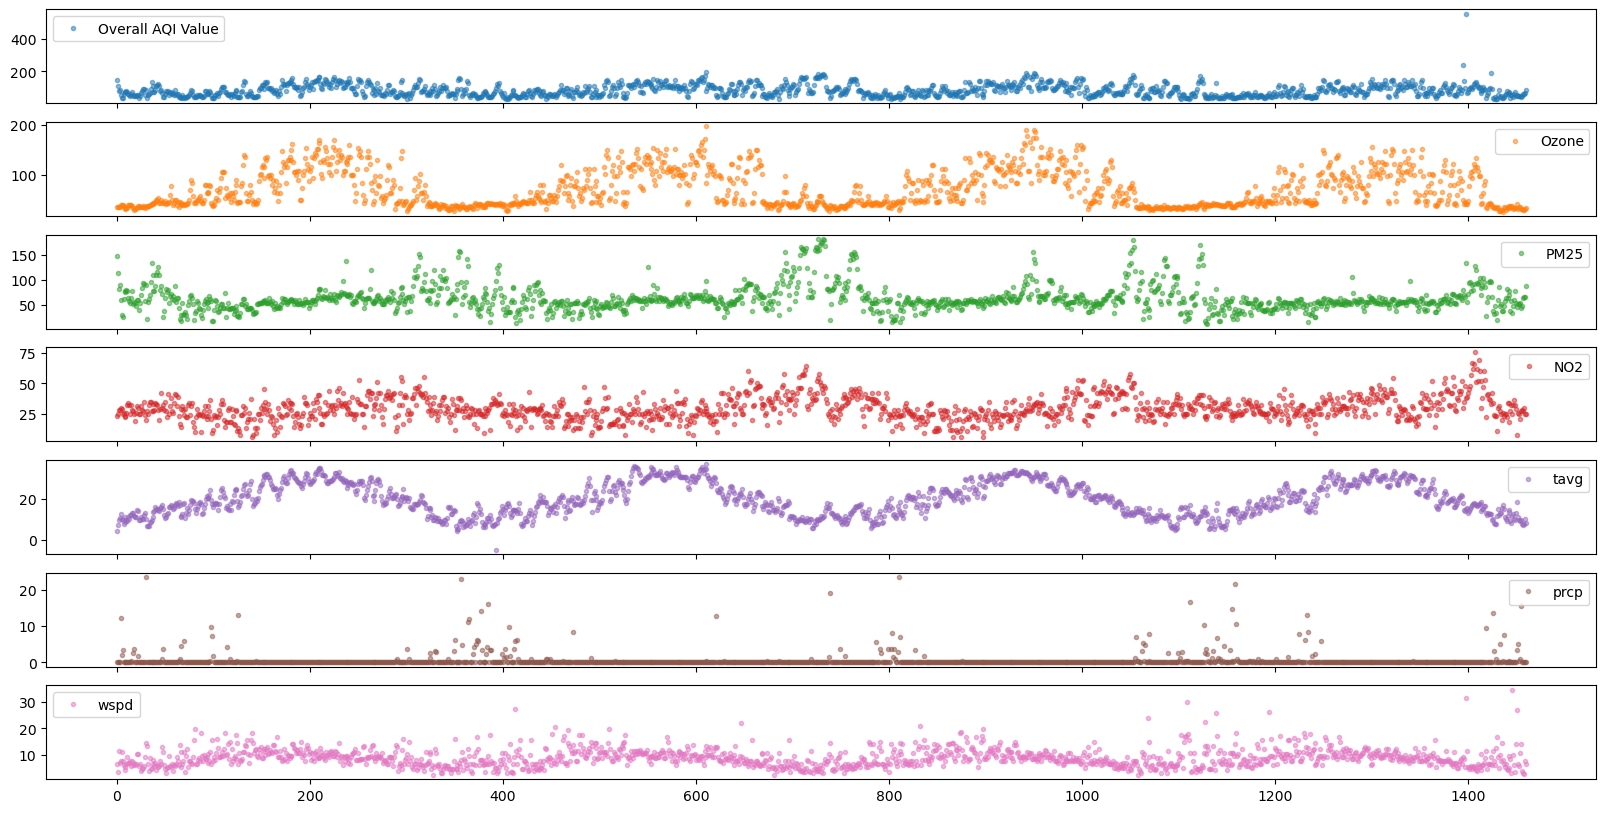

In [77]:
colsplot= ['Overall AQI Value','CO','Ozone','PM10','PM25','NO2','tavg','prcp','wspd']
axes= BF_wet_aqi_data[colsplot].plot(marker='.',alpha=0.5, linestyle= 'none', figsize=(20,10), subplots= True)

# Applying PCC

In [78]:
BF_wet_aqi_data = BF_wet_aqi_data.select_dtypes(include=[np.number])
BF_wet_aqi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Overall AQI Value  1461 non-null   int64  
 1   Ozone              1461 non-null   int64  
 2   PM25               1461 non-null   int64  
 3   NO2                1461 non-null   int64  
 4   tavg               1461 non-null   float64
 5   tmin               1461 non-null   float64
 6   tmax               1461 non-null   float64
 7   prcp               1461 non-null   float64
 8   snow               1461 non-null   float64
 9   wdir               1461 non-null   float64
 10  wspd               1461 non-null   float64
 11  pres               1461 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 137.1 KB


In [79]:
cor = BF_wet_aqi_data.corr()
cor_target = abs(cor['Overall AQI Value'])
relevant_features = cor_target[cor_target > 0.2]
print(relevant_features)

Overall AQI Value    1.000000
Ozone                0.693945
PM25                 0.642260
NO2                  0.377443
tavg                 0.429838
tmin                 0.391981
tmax                 0.488471
prcp                 0.200822
Name: Overall AQI Value, dtype: float64


In [80]:
pcc_data= filter_correlated_columns(BF_wet_aqi_data, 'Overall AQI Value', threshold=0.2)

In [81]:
pcc_data['AQI Label']= pcc_data['Overall AQI Value'].apply(func=label_gen) #Applying the label_gen function
pcc_data.drop(['Overall AQI Value'],axis=1, inplace=True)
pcc_data= pd.DataFrame(pcc_data)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [82]:
X = pcc_data
Y = pcc_data['AQI Label']
X.drop('AQI Label', axis=1, inplace=True)
X = sc.fit_transform(X)
Y= le.fit_transform(Y)
xtrain,xtest,ytrain,ytest= train_test_split(X,Y, test_size= 0.3, random_state= 5)

if min(Counter(ytrain).values()) < 2:
    ros = RandomOverSampler(random_state=5)
    x_train_smote, y_train_smote = ros.fit_resample(xtrain, ytrain)
else:
    smote = SMOTE(random_state=5, k_neighbors=1)
    x_train_smote, y_train_smote = smote.fit_resample(xtrain, ytrain)

In [83]:
print("The Best Machine Learning Algorithm",get_best_algorithm(x_train_smote, y_train_smote))

The Best Machine Learning Algorithm CatBoost


# CatBoost

In [84]:
model3.fit(x_train_smote, y_train_smote)
pred3= model3.predict(xtest)
cr3= classification_report(ytest, pred3)
print(cr3)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        71
           2       0.98      0.98      0.98       231
           3       0.95      1.00      0.97        18
           4       1.00      0.97      0.99       118
           5       0.00      0.00      0.00         1

    accuracy                           0.98       439
   macro avg       0.78      0.79      0.78       439
weighted avg       0.98      0.98      0.98       439



Text(95.72222222222221, 0.5, 'Actual')

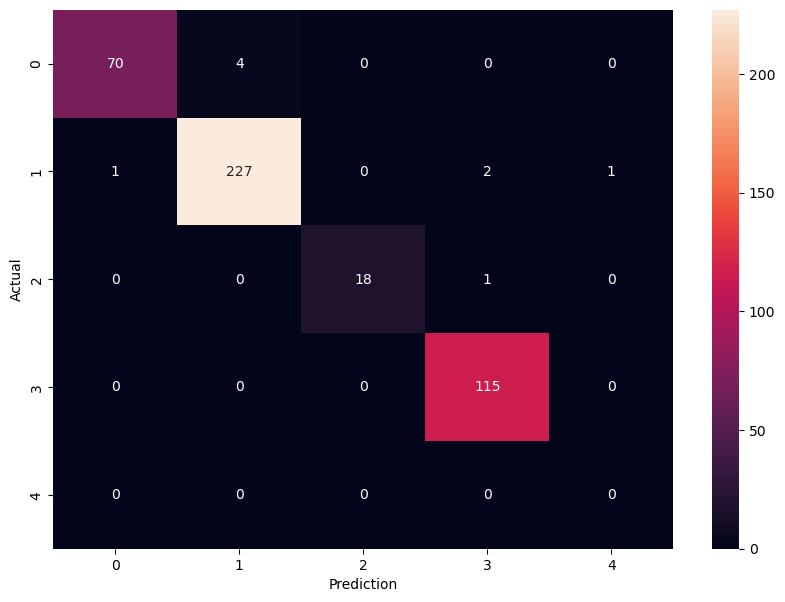

In [85]:
cm= confusion_matrix(pred3, ytest)
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot= True, fmt= 'd')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [86]:
A3 = accuracy_score(ytest, pred3)*100
P3 = precision_score(ytest, pred3, average='weighted',zero_division=0)*100
R3 = recall_score(ytest, pred3, average='weighted',zero_division=0)*100
f1_3 = f1_score(ytest, pred3, average='weighted',zero_division=0)*100

print("CatBoost Accuracy:",A3)
print("CatBoost Precision:", P3)
print("CatBoost Recall:", R3)
print("CatBoost F1 Score: ", f1_3)

CatBoost Accuracy: 97.9498861047836
CatBoost Precision: 97.77102363123224
CatBoost Recall: 97.9498861047836
CatBoost F1 Score:  97.84645201519898


In [87]:
scores = cross_val_score(model3, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 99.64690443106377


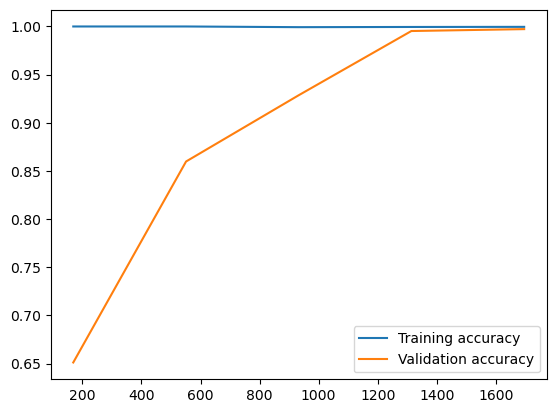

In [88]:
train_sizes, train_scores, test_scores = learning_curve(model3, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()

# GradientBoost

In [89]:
model7.fit(x_train_smote, y_train_smote)
pred7= model7.predict(xtest)
cr7=classification_report(ytest,pred7, zero_division=0)
print(cr7)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        71
           2       0.99      0.98      0.98       231
           3       0.95      1.00      0.97        18
           4       1.00      0.97      0.99       118
           5       0.00      0.00      0.00         1

    accuracy                           0.98       439
   macro avg       0.78      0.79      0.78       439
weighted avg       0.98      0.98      0.98       439



Text(95.72222222222221, 0.5, 'Actual')

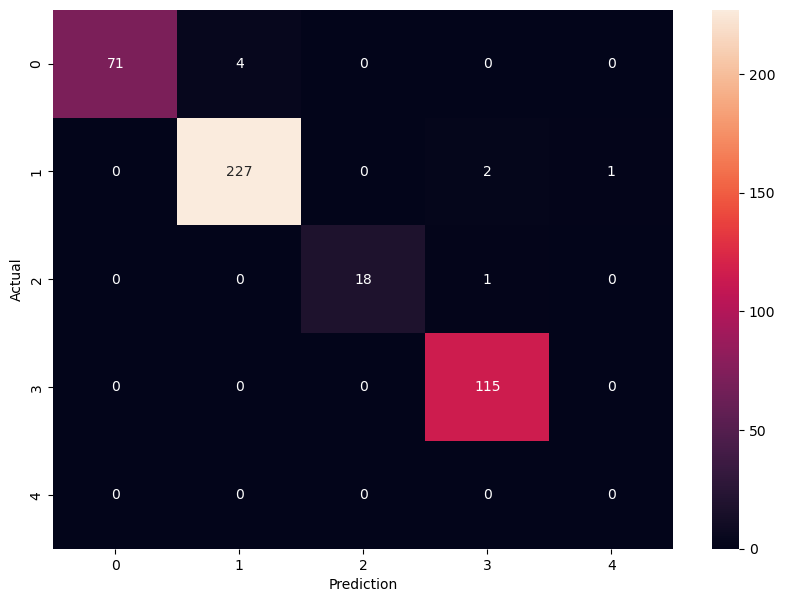

In [90]:
cm= confusion_matrix(pred7, ytest)
plt.figure(figsize= (10,7))
sn.heatmap(cm, annot= True, fmt= 'd')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [91]:
A7 = accuracy_score(ytest, pred7)*100
P7 = precision_score(ytest, pred7, average='weighted',zero_division=0)*100
R7 = recall_score(ytest, pred7, average='weighted',zero_division=0)*100
f1_7 = f1_score(ytest, pred7, average='weighted',zero_division=0)*100

print("GradientBoost Accuracy:",A7)
print("GradientBoost Precision:", P7)
print("GradientBoost Recall:", R7)
print("GradientBoost F1 Score:", f1_7)

GradientBoost Accuracy: 98.17767653758543
GradientBoost Precision: 98.00749918770383
GradientBoost Recall: 98.17767653758543
GradientBoost F1 Score: 98.07321242333738


In [92]:
scores = cross_val_score(model7, x_train_smote, y_train_smote, cv=10)
print("Cross-Validation Accuracy:", scores.mean()*100)

Cross-Validation Accuracy: 99.6072255673923


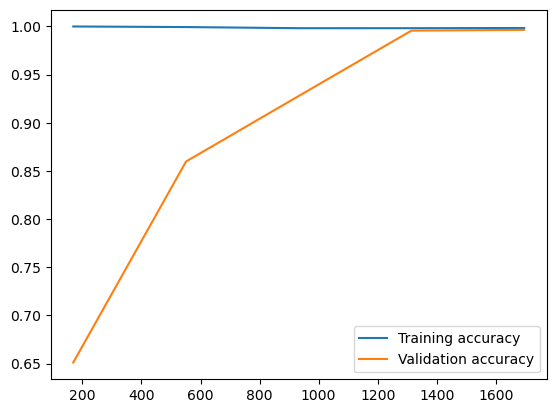

In [93]:
train_sizes, train_scores, test_scores = learning_curve(model7, x_train_smote, y_train_smote, cv=3)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.legend()
plt.show()